# Lab time series analysis: COVID-19 data


In this lab assignment, we will make use of the COVID-19 dataset maintained by [Our World in Data](https://ourworldindata.org/coronavirus), published on Github at <https://github.com/owid/covid-19-data/tree/master/public/data>.

In [1]:
# Package imports for data science and time series analysis in particular
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd;
import scipy.stats as stats;
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error
from statsmodels.graphics.mosaicplot import mosaic
from statsmodels.tsa.api import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

First, we import the dataset, parse the `date` column as the Python `DateTime` type and set this as the index:

In [2]:
covid19 = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', parse_dates=['date']).set_index(['date'])
covid19.head()

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,
2020-02-24,AFG,Asia,Afghanistan,5.0,5.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-25,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-26,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-27,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-28,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


Create a new `DataFrame` (with name e.g. `covid19_be`) that only contains the new cases in Belgium and use the `plot()` method of `DataFrame` to visualize it. Increase the size of the picture with the `figsize` parameter, otherwise it will be too small.

<AxesSubplot:xlabel='date'>

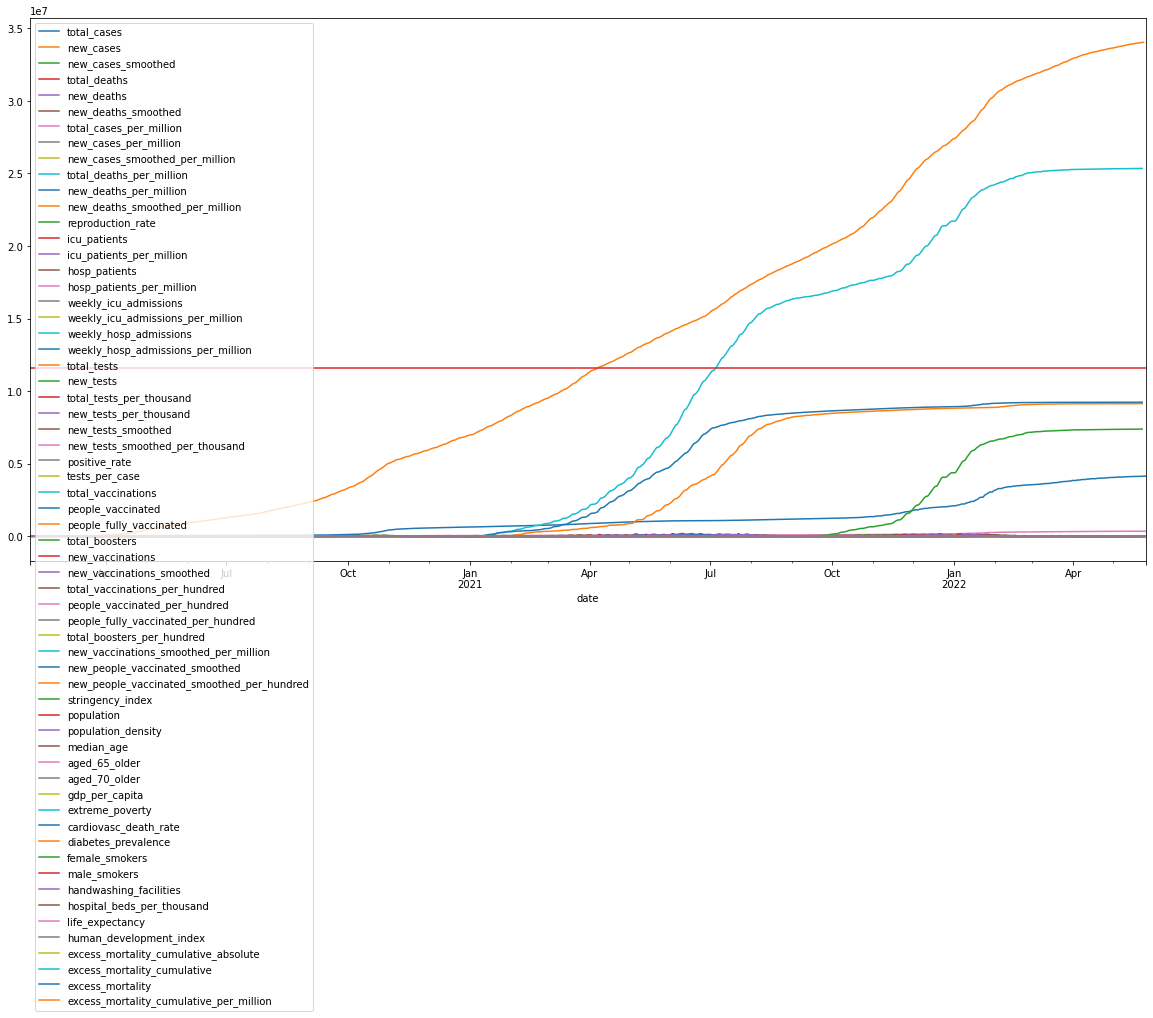

In [3]:
covid19_be = covid19[covid19['location'] == 'Belgium']
covid19_be.plot(figsize=(20,10))

## Moving average

Add new columns to the data frame with new cases in Belgium with the simple moving average for 7 and 30 days. Plot the entire data frame (observations and both moving averages).

In [4]:
covid19_be.head(10)

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,
2020-02-04,BEL,Europe,Belgium,1.0,1.0,NaN,NaN,NaN,NaN,0.086,...,25.1,31.4,NaN,5.64,81.63,0.931,NaN,NaN,NaN,NaN
2020-02-05,BEL,Europe,Belgium,1.0,0.0,NaN,NaN,NaN,NaN,0.086,...,25.1,31.4,NaN,5.64,81.63,0.931,NaN,NaN,NaN,NaN
2020-02-06,BEL,Europe,Belgium,1.0,0.0,NaN,NaN,NaN,NaN,0.086,...,25.1,31.4,NaN,5.64,81.63,0.931,NaN,NaN,NaN,NaN
2020-02-07,BEL,Europe,Belgium,1.0,0.0,NaN,NaN,NaN,NaN,0.086,...,25.1,31.4,NaN,5.64,81.63,0.931,NaN,NaN,NaN,NaN
2020-02-08,BEL,Europe,Belgium,1.0,0.0,NaN,NaN,NaN,NaN,0.086,...,25.1,31.4,NaN,5.64,81.63,0.931,NaN,NaN,NaN,NaN
2020-02-09,BEL,Europe,Belgium,1.0,0.0,0.143,NaN,NaN,NaN,0.086,...,25.1,31.4,NaN,5.64,81.63,0.931,-970.0,-6.63,-12.66,-83.388252
2020-02-10,BEL,Europe,Belgium,1.0,0.0,0.143,NaN,NaN,NaN,0.086,...,25.1,31.4,NaN,5.64,81.63,0.931,NaN,NaN,NaN,NaN
2020-02-11,BEL,Europe,Belgium,1.0,0.0,0.000,NaN,NaN,NaN,0.086,...,25.1,31.4,NaN,5.64,81.63,0.931,NaN,NaN,NaN,NaN
2020-02-12,BEL,Europe,Belgium,1.0,0.0,0.000,NaN,NaN,NaN,0.086,...,25.1,31.4,NaN,5.64,81.63,0.931,NaN,NaN,NaN,NaN


In [5]:
covid19_be['SMA7'] = covid19_be['new_cases'].rolling(window=7).mean()
covid19_be['SMA30'] = covid19_be['new_cases'].rolling(window=30).mean()

C:\Users\szymo\AppData\Local\Temp\ipykernel_13524\1595365658.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid19_be['SMA7'] = covid19_be['new_cases'].rolling(window=7).mean()
C:\Users\szymo\AppData\Local\Temp\ipykernel_13524\1595365658.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid19_be['SMA30'] = covid19_be['new_cases'].rolling(window=30).mean()


<AxesSubplot:xlabel='date'>

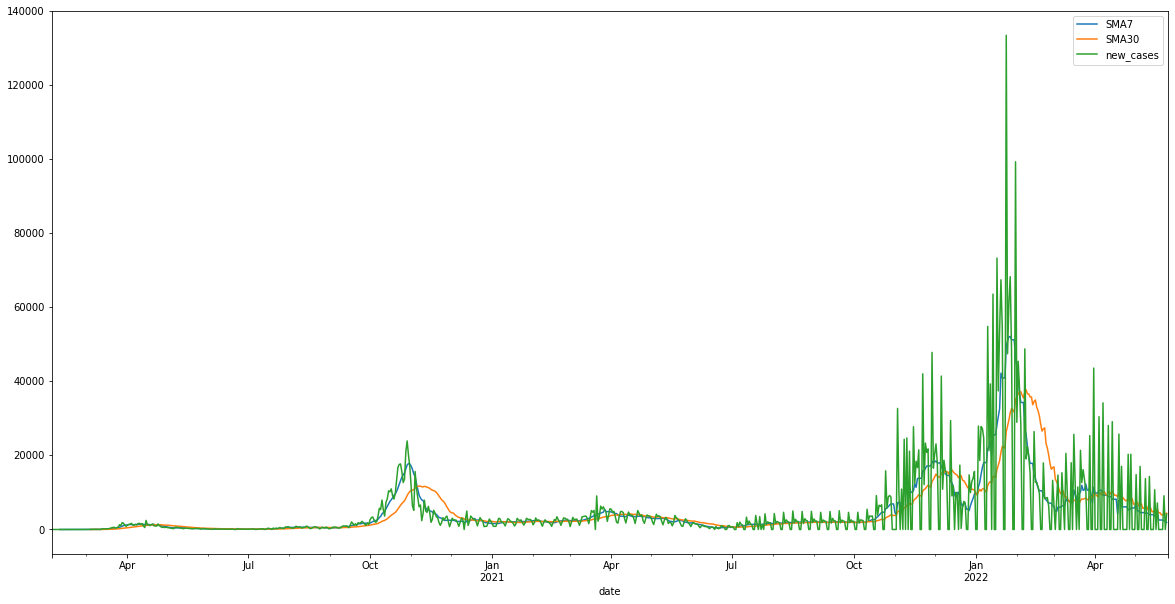

In [6]:
covid19_be.plot(y=['SMA7','SMA30','new_cases'],figsize=(20,10))

## Holt-Winters model for new cases early 2021

The period from about December 2020 up to the end of February 2021 seems quite regular. Create a new `DataFrame` and select only the observations during that period (1 December 2021 to 28 February 2022). Plot the `DataFrame` (it will still contain the moving averages from the previous step).

<AxesSubplot:xlabel='date'>

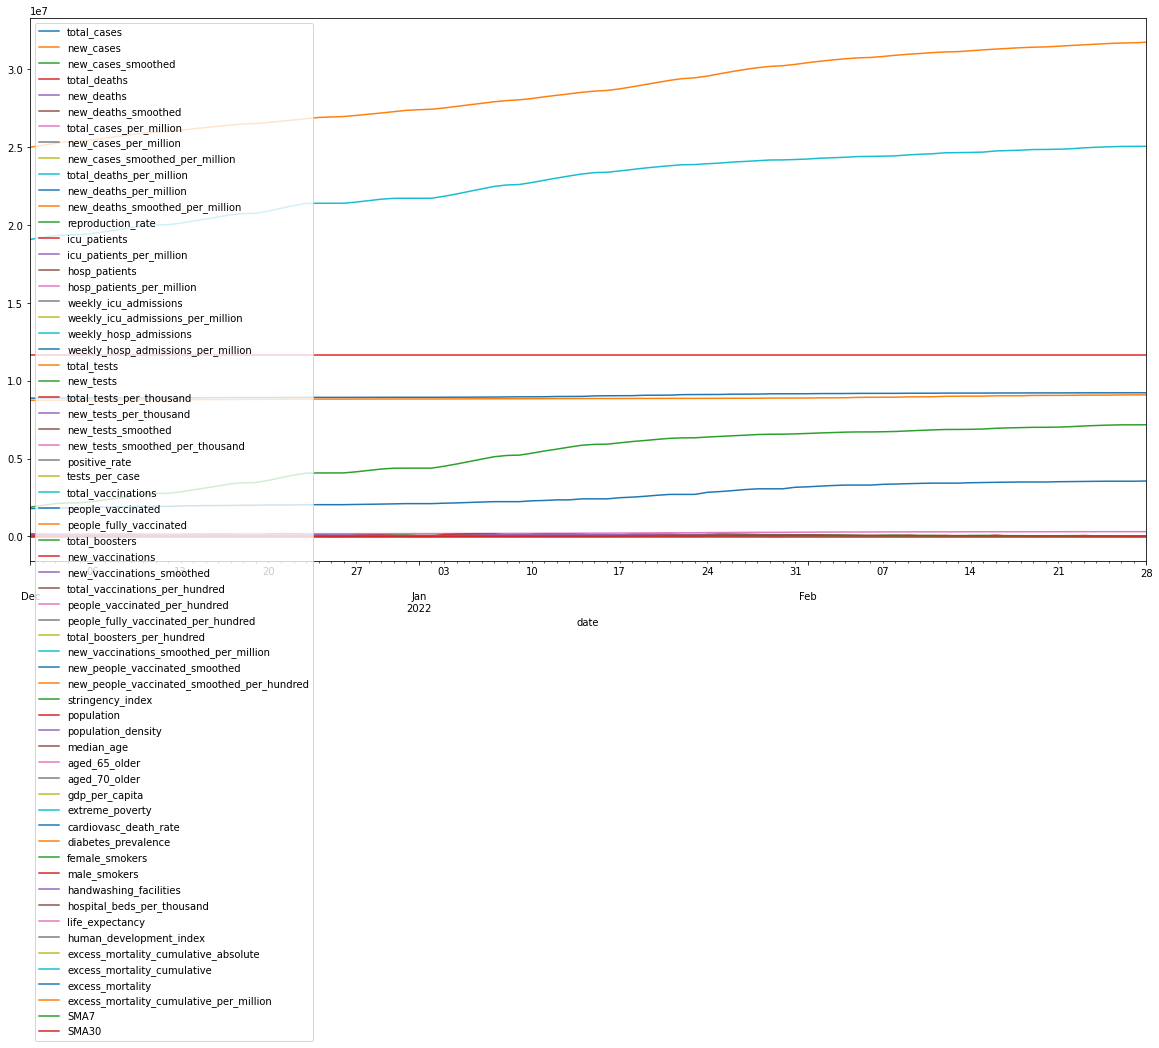

In [7]:
# Create a new DataFrame and select only the observations during 1 December 2021 to 28 February 2022. Plot the DataFrame
covid19_be_2021_2022 = covid19_be[(covid19_be.index >= '2021-12-01') & (covid19_be.index <= '2022-02-28')]
covid19_be_2021_2022.plot(figsize=(20,10))





Build a Holt-Winters model for the observed new cases during that period.

Use the additive type for both trend and seasonal smoothing. Set the value for `seasonal_periods` to the appropriate value! Plot the observed and fitted values.

c:\Users\szymo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\szymo\AppData\Local\Temp\ipykernel_13524\4253016443.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid19_be_2021_2022['SES'] = data_ses.fittedvalues


<AxesSubplot:xlabel='date'>

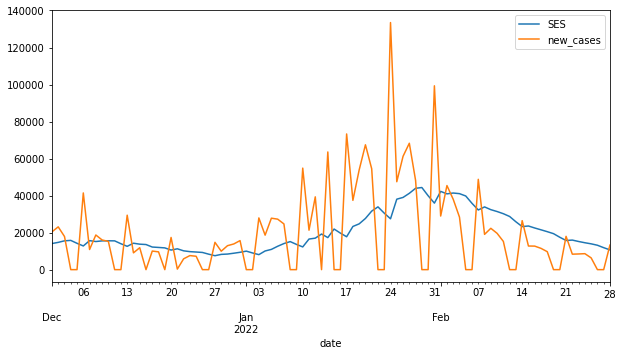

In [8]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
data_ses = SimpleExpSmoothing(covid19_be_2021_2022['new_cases']).fit(smoothing_level=0.1)
covid19_be_2021_2022['SES'] = data_ses.fittedvalues
covid19_be_2021_2022.plot(y=['SES',  'new_cases'], figsize=[10,5])


<AxesSubplot:xlabel='date'>

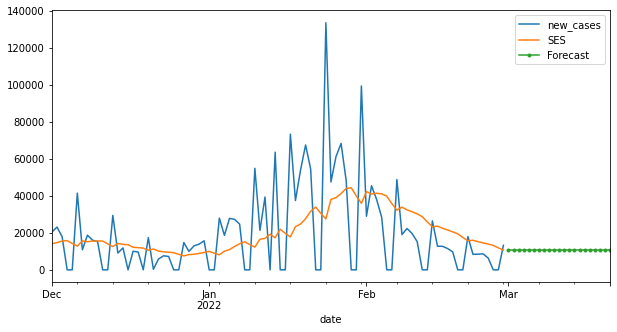

In [9]:
data_ses_fcast = data_ses.forecast(21)

covid19_be_2021_2022.plot(y=['new_cases',  'SES'], figsize=[10,5])
data_ses_fcast.plot(marker='.', legend=True, label='Forecast')

c:\Users\szymo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\szymo\AppData\Local\Temp\ipykernel_13524\3051355144.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid19_be_2021_2022['seasonal_periods'] = data_des.fittedvalues


<AxesSubplot:xlabel='date'>

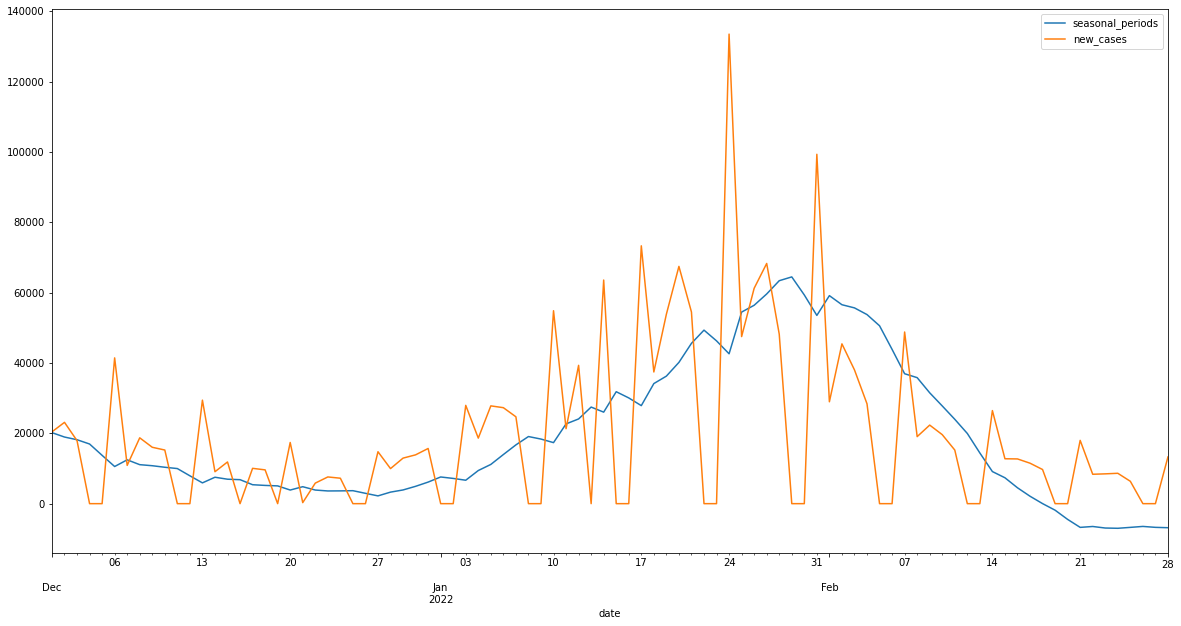

In [10]:
from statsmodels.tsa.api import Holt
data_des = Holt(covid19_be_2021_2022['new_cases']).fit(smoothing_level=.1, smoothing_trend=.2)
covid19_be_2021_2022['seasonal_periods'] = data_des.fittedvalues
covid19_be_2021_2022.plot(y=['seasonal_periods','new_cases'],figsize=(20,10))


Now, make a forecast for 21 days and plot observed and forecasted values. What do you notice when you compare observed and forecasted values as time progresses?

<AxesSubplot:xlabel='date'>

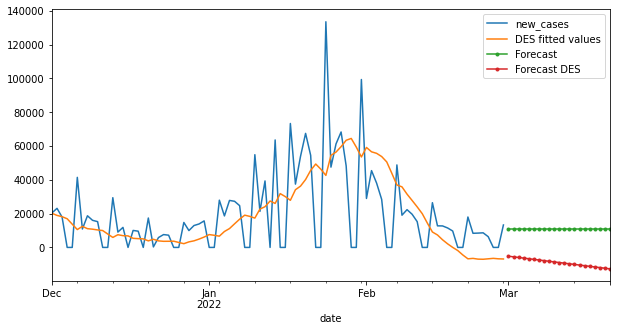

In [11]:
data_des_fcast = data_des.forecast(21)

covid19_be_2021_2022['new_cases'].plot( legend=True) # Observations
covid19_be_2021_2022['seasonal_periods'].plot(legend=True, label='DES fitted values', figsize=[10,5])              
# covid19_be_2021_2022['SMA7'].plot(legend=True, label='SMA7')
# covid19_be_2021_2022['SMA30'].plot(legend=True, label='SMA30')
data_ses_fcast.plot(marker='.', legend=True, label='Forecast')
data_des_fcast.plot(marker='.', legend=True, label='Forecast DES') 

In [12]:
covid19_be_2021_2022['new_cases']

date
2021-12-01    20409.0
2021-12-02    23113.0
2021-12-03    17910.0
2021-12-04        0.0
2021-12-05        0.0
               ...   
2022-02-24     8634.0
2022-02-25     6359.0
2022-02-26        0.0
2022-02-27        0.0
2022-02-28    13280.0
Name: new_cases, Length: 90, dtype: float64

In [13]:
data_des_fcast

2022-03-01    -5200.002589
2022-03-02    -5573.750666
2022-03-03    -5947.498744
2022-03-04    -6321.246821
2022-03-05    -6694.994899
2022-03-06    -7068.742976
2022-03-07    -7442.491054
2022-03-08    -7816.239131
2022-03-09    -8189.987209
2022-03-10    -8563.735286
2022-03-11    -8937.483364
2022-03-12    -9311.231441
2022-03-13    -9684.979519
2022-03-14   -10058.727596
2022-03-15   -10432.475673
2022-03-16   -10806.223751
2022-03-17   -11179.971828
2022-03-18   -11553.719906
2022-03-19   -11927.467983
2022-03-20   -12301.216061
2022-03-21   -12674.964138
Freq: D, dtype: float64

In [14]:
data_ses_fcast

2022-03-01    10940.565855
2022-03-02    10940.565855
2022-03-03    10940.565855
2022-03-04    10940.565855
2022-03-05    10940.565855
2022-03-06    10940.565855
2022-03-07    10940.565855
2022-03-08    10940.565855
2022-03-09    10940.565855
2022-03-10    10940.565855
2022-03-11    10940.565855
2022-03-12    10940.565855
2022-03-13    10940.565855
2022-03-14    10940.565855
2022-03-15    10940.565855
2022-03-16    10940.565855
2022-03-17    10940.565855
2022-03-18    10940.565855
2022-03-19    10940.565855
2022-03-20    10940.565855
2022-03-21    10940.565855
Freq: D, dtype: float64

c:\Users\szymo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\szymo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<AxesSubplot:xlabel='date'>

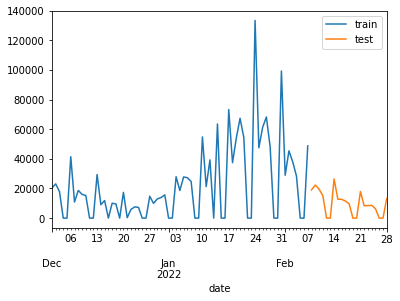

In [15]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train = covid19_be_2021_2022['new_cases'][:len(covid19_be_2021_2022)-21]
test = covid19_be_2021_2022['new_cases'][len(covid19_be_2021_2022)-21:]

newCases_hw = ExponentialSmoothing(train,
  trend='add', seasonal='add',
  seasonal_periods=21).fit()

train.plot(legend=True, label='train')
test.plot(legend=True, label='test')



Text(0.5, 1.0, 'Train, test, fitted & predicted values using Holt-Winters')

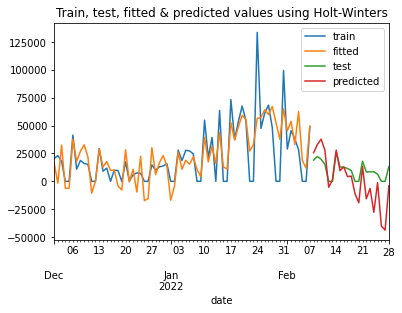

In [16]:
newCases_predicted = newCases_hw.forecast(21)

train.plot(legend=True, label='train')
newCases_hw.fittedvalues.plot(legend=True, label='fitted')

test.plot(legend=True, label='test')
newCases_predicted.plot(legend=True, label='predicted')

plt.title('Train, test, fitted & predicted values using Holt-Winters')

Text(0.5, 1.0, 'Test data vs. predicted values')

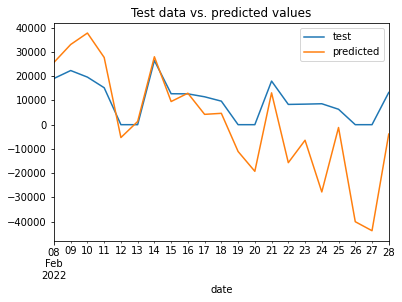

In [17]:
test.plot(legend=True, label='test')
newCases_predicted.plot(legend=True, label='predicted')
plt.title('Test data vs. predicted values')

In [18]:
newCases_predicted

2022-02-08    25685.560400
2022-02-09    33072.135749
2022-02-10    37795.407167
2022-02-11    27726.420345
2022-02-12    -5307.969197
2022-02-13     1309.585605
2022-02-14    28012.036113
2022-02-15     9548.776184
2022-02-16    12980.224760
2022-02-17     4259.111091
2022-02-18     4684.295846
2022-02-19   -11056.012501
2022-02-20   -19232.729575
2022-02-21    13128.677013
2022-02-22   -15666.144154
2022-02-23    -6427.330388
2022-02-24   -27746.697783
2022-02-25    -1167.959655
2022-02-26   -40018.676826
2022-02-27   -43733.301750
2022-02-28    -3869.774665
Freq: D, dtype: float64

In [19]:
newCases_hw.params_formatted

,name,param,optimized
smoothing_level,alpha,0.181786,True
smoothing_trend,beta,0.181786,True
smoothing_seasonal,gamma,0.000100,True
initial_level,l.0,11996.244444,True
initial_trend,b.0,-396.775180,True
initial_seasons.0,s.0,5129.116780,True
initial_seasons.1,s.1,-13653.883220,True
initial_seasons.2,s.2,15472.021542,True
initial_seasons.3,s.3,-20842.668934,True
initial_seasons.4,s.4,-22018.287982,True


## Evaluating model quality


- Calculate the Mean Squared Error for a forecast period of 7 days, and compare its square root with the standard deviation of observed new cases over the test period and forecasted period combined.
- Do the same for a forecast period of 14 and 21 days.
- For which period is the quality of the forecast ok?

The expected results are shown in the table below:

|     Forecast period      |         MSE |     √MSE |    stdev |
| :----------------------: | ----------: | -------: | -------: |
| 2021-03-01 to 2021-03-07 |   64617.220 |  254.199 |  811.826 |
| 2021-03-01 to 2021-03-14 |  208014.899 |  456.087 |  837.483 |
| 2021-03-01 to 2021-03-21 | 3228834.183 | 1796.896 | 1154.486 |

In [20]:
newCases_predicted

2022-02-08    25685.560400
2022-02-09    33072.135749
2022-02-10    37795.407167
2022-02-11    27726.420345
2022-02-12    -5307.969197
2022-02-13     1309.585605
2022-02-14    28012.036113
2022-02-15     9548.776184
2022-02-16    12980.224760
2022-02-17     4259.111091
2022-02-18     4684.295846
2022-02-19   -11056.012501
2022-02-20   -19232.729575
2022-02-21    13128.677013
2022-02-22   -15666.144154
2022-02-23    -6427.330388
2022-02-24   -27746.697783
2022-02-25    -1167.959655
2022-02-26   -40018.676826
2022-02-27   -43733.301750
2022-02-28    -3869.774665
Freq: D, dtype: float64

In [21]:
test

date
2022-02-08    19057.0
2022-02-09    22333.0
2022-02-10    19616.0
2022-02-11    15242.0
2022-02-12        0.0
2022-02-13        0.0
2022-02-14    26458.0
2022-02-15    12762.0
2022-02-16    12714.0
2022-02-17    11503.0
2022-02-18     9705.0
2022-02-19        0.0
2022-02-20        0.0
2022-02-21    17989.0
2022-02-22     8356.0
2022-02-23     8473.0
2022-02-24     8634.0
2022-02-25     6359.0
2022-02-26        0.0
2022-02-27        0.0
2022-02-28    13280.0
Name: new_cases, dtype: float64

In [22]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

print(f'MAE = {mean_absolute_error(test,newCases_predicted)}')
print(f'MSE = {mean_squared_error(test,newCases_predicted)}')

MAE = 13848.95745226951
MSE = 346155268.58387417


In [23]:
print(f'√MSE  = {np.sqrt(mean_squared_error(test,newCases_predicted))}')
print(f'stdev = {covid19_be_2021_2022.new_cases.std()}')

√MSE  = 18605.24841500038
stdev = 24202.475037817512


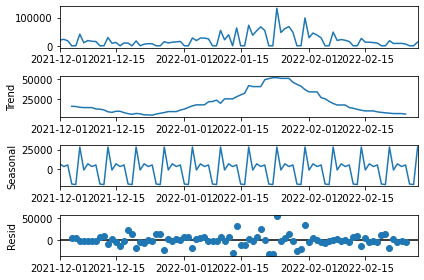

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

# remove other columns (e.g. SES, DES, ...)
covid19_be_2021_2022 = covid19_be_2021_2022[['new_cases']]

newcases_decomposed = seasonal_decompose(covid19_be_2021_2022, model='additive')
newcases_decomposed.plot();

## ICU patients

Create a new `DataFrame` with only the total number of ICU (intensive care units) patients in the Belgian hospitals. Make sure that all NaN's are removed, since time series analysis functions can't cope with missing values. Plot this time series. 

In [25]:
ICU = pd.DataFrame(covid19_be)


In [26]:
ICU = ICU['icu_patients'].dropna()

In [27]:
ICU

date
2020-03-15     53.0
2020-03-16     79.0
2020-03-17    100.0
2020-03-18    130.0
2020-03-19    164.0
              ...  
2022-05-21     91.0
2022-05-22     93.0
2022-05-23     90.0
2022-05-24     90.0
2022-05-25     86.0
Name: icu_patients, Length: 802, dtype: float64

<AxesSubplot:xlabel='date'>

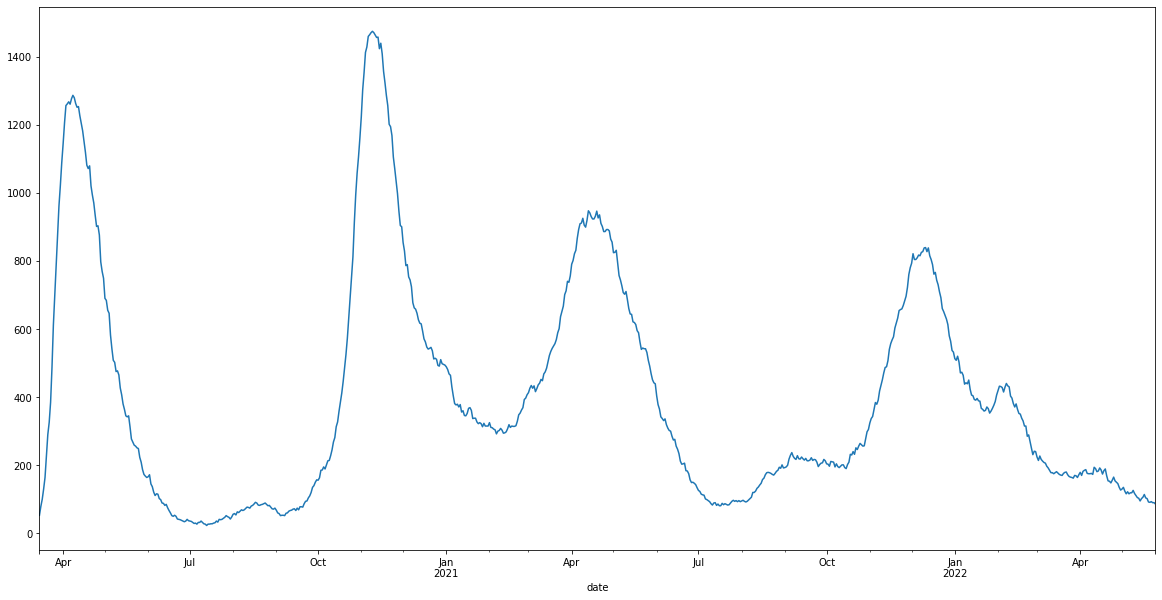

In [28]:
ICU.plot(figsize=(20,10))

In [29]:
print(ICU)

date
2020-03-15     53.0
2020-03-16     79.0
2020-03-17    100.0
2020-03-18    130.0
2020-03-19    164.0
              ...  
2022-05-21     91.0
2022-05-22     93.0
2022-05-23     90.0
2022-05-24     90.0
2022-05-25     86.0
Name: icu_patients, Length: 802, dtype: float64


In [40]:
ICU = ICU.to_frame()

In [41]:
ICU

,icu_patients
date,
2020-03-15,53
2020-03-16,79
2020-03-17,100
2020-03-18,130
2020-03-19,164
...,...
2022-05-21,91
2022-05-22,93
2022-05-23,90


In [37]:
#set the value type from ICU to numeric
# ICU = ICU['icu_patients'].astype(int)

In [42]:
ICU['patients']  = ICU['icu_patients']


In [43]:
ICU.drop('icu_patients', axis=1, inplace=True)

In [44]:
ICU.head()

,patients
date,
2020-03-15,53
2020-03-16,79
2020-03-17,100
2020-03-18,130
2020-03-19,164


Build a duible exponential smoothing (Holt) model of this time series. Make a forecast of 70 time units and plot the observations, fitted values and forecast.

Are we currently in an upward or downward trend, according to this model? Do the forecasted values seem reasonable if you look at the last period?

c:\Users\szymo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<AxesSubplot:xlabel='date'>

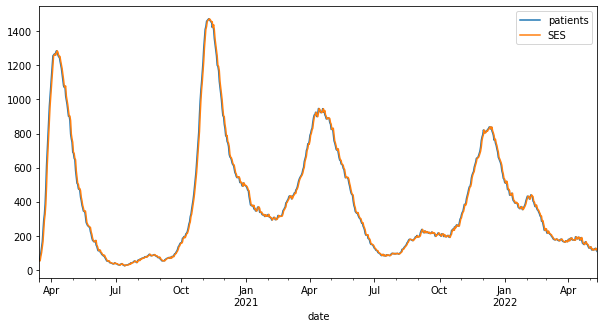

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
data_ses = SimpleExpSmoothing(ICU['patients']).fit()
ICU['SES'] = data_ses.fittedvalues
ICU.plot(y=['patients',  'SES'], figsize=[10,5])


<AxesSubplot:xlabel='date'>

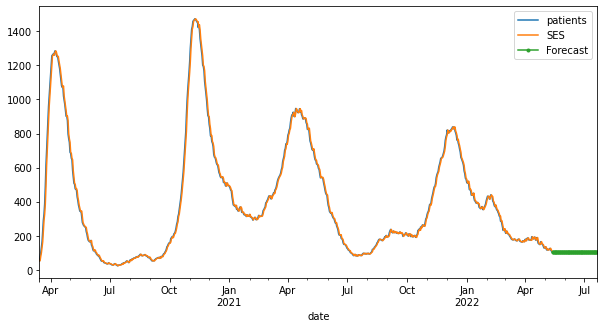

In [ ]:
ICU_ses_fcast = data_ses.forecast(70)

ICU.plot(y=['patients',  'SES'], figsize=[10,5])
ICU_ses_fcast.plot(marker='.', legend=True, label='Forecast')

c:\Users\szymo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<AxesSubplot:xlabel='date'>

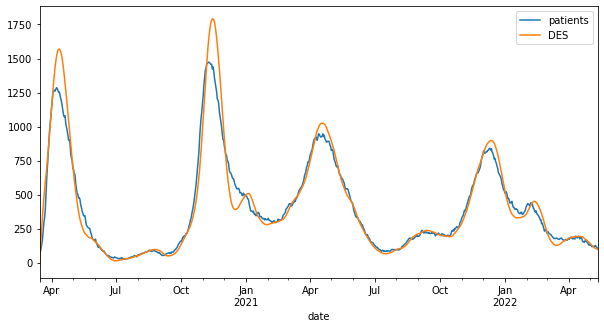

In [ ]:
from statsmodels.tsa.api import Holt

data_des = Holt(ICU['patients']).fit(smoothing_level=.1, smoothing_trend=.2)

ICU['DES'] = data_des.fittedvalues
ICU.plot(y=['patients',  'DES'], figsize=[10,5])

<AxesSubplot:xlabel='date'>

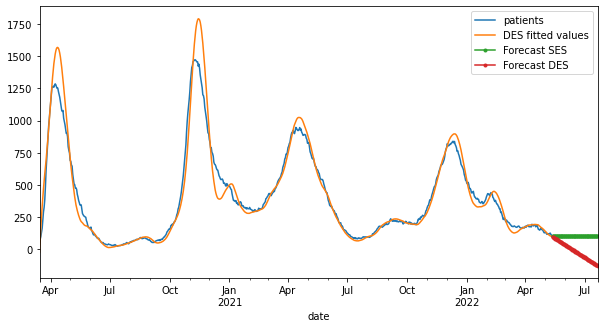

In [ ]:
data_des_fcast = data_des.forecast(70)

ICU['patients'].plot( legend=True) # Observations
ICU['DES'].plot(legend=True, label='DES fitted values', figsize=[10,5])              
ICU_ses_fcast.plot(marker='.', legend=True, label='Forecast SES')
data_des_fcast.plot(marker='.', legend=True, label='Forecast DES') 

Since we didn't set any initial parameters like $\alpha$ and $\beta$, the model calculated them using some rule of thumb. List these parameters from the model:

In [ ]:
# data_des = Holt(ICU['patients']).fit(smoothing_level=.1, smoothing_trend=.2) ??

What were the final estimated values for the level and trend, that are used in the forecast? In other words, what are the parameters of the line that estimates future observations?

Let's try to set the parameters ourselves. Recreate the Holt-model with $\alpha = \beta = 0.1$. Calculate a forecast like before and plot.

c:\Users\szymo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<AxesSubplot:xlabel='date'>

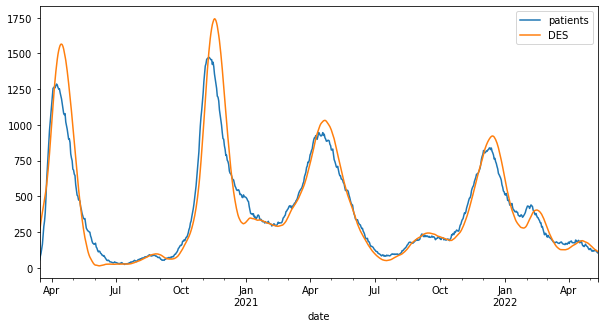

In [ ]:
from statsmodels.tsa.api import Holt

data_des = Holt(ICU['patients']).fit(smoothing_level=.1, smoothing_trend=.1)

ICU['DES'] = data_des.fittedvalues
ICU.plot(y=['patients',  'DES'], figsize=[10,5])

<AxesSubplot:xlabel='date'>

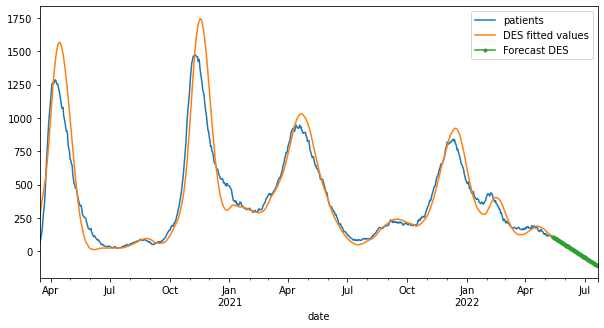

In [ ]:
data_des_fcast = data_des.forecast(70)

ICU['patients'].plot( legend=True) # Observations
ICU['DES'].plot(legend=True, label='DES fitted values', figsize=[10,5])              
data_des_fcast.plot(marker='.', legend=True, label='Forecast DES') 

Compare the model parameters and final estimates. Which of the two forecast models seems to perform best if you look at the plots?